In [1]:
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
%matplotlib widget
%load_ext autoreload
%autoreload 2
plt.style.use('presentation.mplstyle')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
import scipy
import statsmodels.api as sm
import hashlib

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
junction_table = pd.read_csv('junctions.csv')

In [9]:
junction_table = junction_table.loc[junction_table['min_width']>0]
junction_table

,Unnamed: 0,min_width,middle_width,max_width,min_length,min_max_ratio,midle_max_ratio
0,0,6.228456,8.145288,8.628065,315.857213,0.721883,0.944046
1,1,4.546822,5.056562,6.105913,925.428922,0.744659,0.828142
2,2,4.855766,5.723332,5.960308,302.096031,0.814684,0.960241
4,4,3.611754,5.056562,5.757743,249.182039,0.627286,0.878219
10,10,4.900687,4.983920,5.757743,2302.600188,0.851147,0.865603
...,...,...,...,...,...,...,...
1261,1261,13.835636,14.129396,16.573822,249.343865,0.834789,0.852513
1262,1262,2.857101,4.348146,4.348577,287.123030,0.657020,0.999901
1263,1263,5.226750,5.750354,7.028922,3082.653150,0.743606,0.818099
1264,1264,3.607590,5.054008,5.153348,1117.609503,0.700048,0.980723


(array([  1.,   3.,   6.,   8.,  23.,  43.,  95., 141., 147.,  78.]),
 array([0.15237584, 0.23650971, 0.32064358, 0.40477745, 0.48891132,
        0.57304519, 0.65717905, 0.74131292, 0.82544679, 0.90958066,
        0.99371453]),
 <BarContainer object of 10 artists>)

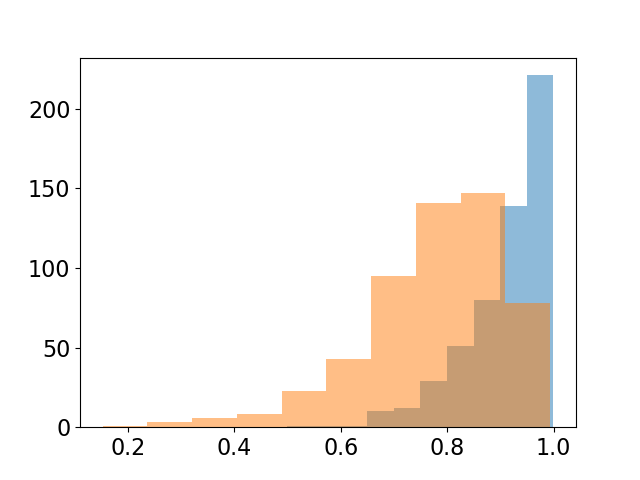

In [8]:
fig,ax = plt.subplots()
ax.hist(junction_table['midle_max_ratio'],alpha = 0.5)
ax.hist(junction_table['min_max_ratio'],alpha = 0.5)

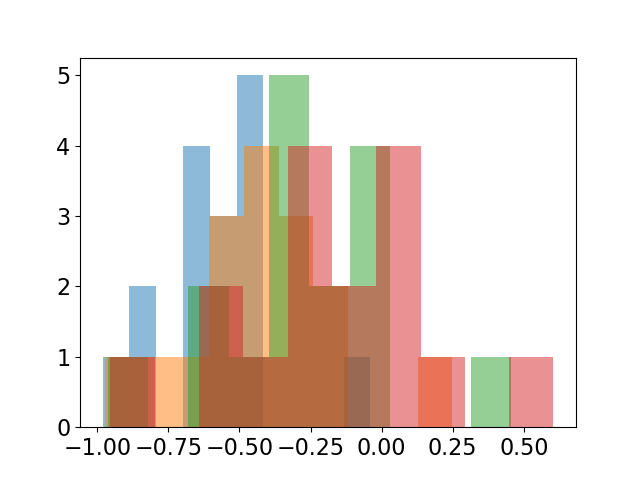

In [16]:
fig,ax = plt.subplots()
select = junction_table.loc[junction_table['min_width']>7]
for n in range(2,6):
    ax.hist(1-select['midle_max_ratio']**n-select['min_max_ratio']**n,10,alpha = 0.5,)


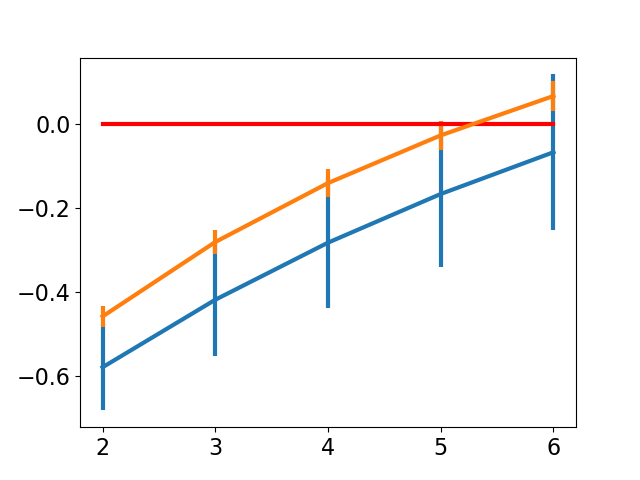

In [27]:
fig,ax = plt.subplots()
select = junction_table.loc[junction_table['min_width']>7]
deviation_from_law = [np.mean(1-select['midle_max_ratio']**n-select['min_max_ratio']**n) for n in range(2,7)]
deviation_from_law_std = [2*np.std(1-select['midle_max_ratio']**n-select['min_max_ratio']**n) for n in range(2,7)]
deviation_from_law_count = [len(1-select['midle_max_ratio']**n-select['min_max_ratio']**n) for n in range(2,7)]
ax.errorbar(range(2,7),deviation_from_law,deviation_from_law_std/np.sqrt(deviation_from_law_count))
select = junction_table.loc[junction_table['min_width']<7]
deviation_from_law = [np.mean(1-select['midle_max_ratio']**n-select['min_max_ratio']**n) for n in range(2,7)]
deviation_from_law_std = [2*np.std(1-select['midle_max_ratio']**n-select['min_max_ratio']**n) for n in range(2,7)]
deviation_from_law_count = [len(1-select['midle_max_ratio']**n-select['min_max_ratio']**n) for n in range(2,7)]
ax.errorbar(range(2,7),deviation_from_law,deviation_from_law_std/np.sqrt(deviation_from_law_count))
ax.plot(range(2,7),[0 for i in range(2,7)],color='red')

In [3]:

N = 10000
r1 = np.random.normal(0,0.2,N)+0.7
r2 = np.random.normal(0,0.2,N)+0.7
maxsr = np.max([r1,r2],axis=0)
minsr = np.min([r1,r2],axis=0)
r3 = np.power(maxsr**3-minsr**3,1/3)

In [4]:
maxsr = np.max([maxsr,minsr,r3],axis=0)
minsr = np.min([maxsr,minsr,r3],axis=0)
middle = np.sort([maxsr,minsr,r3],axis = 0)[1]

(array([2.000e+00, 2.000e+00, 2.600e+01, 8.600e+01, 2.180e+02, 5.400e+02,
        1.007e+03, 1.808e+03, 2.602e+03, 3.709e+03]),
 array([-0.20529593, -0.10539686, -0.00549779,  0.09440128,  0.19430034,
         0.29419941,  0.39409848,  0.49399754,  0.59389661,  0.69379568,
         0.79369475]),
 <BarContainer object of 10 artists>)

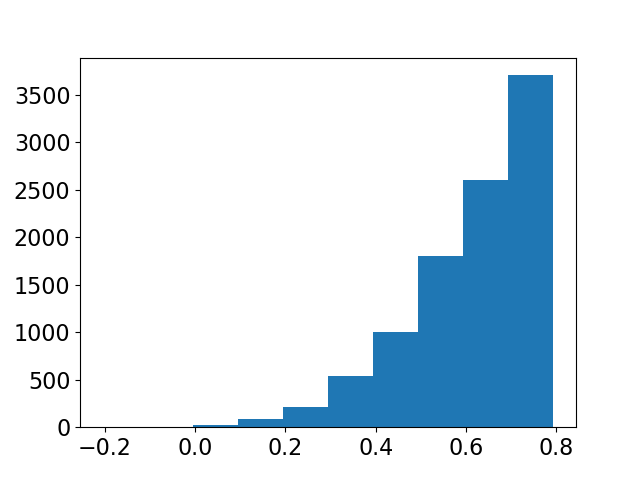

In [5]:
fig,ax = plt.subplots()
ax.hist(minsr/maxsr)

In [6]:
sigma = 0.01
maxsr_noise = maxsr*(1+np.random.normal(0,sigma,N))
minsr_nois = minsr*(1+np.random.normal(0,sigma,N))
r3_noise = r3*(1+np.random.normal(0,sigma,N))

In [7]:
maxsr2 = np.max([maxsr_noise,minsr_nois,r3_noise],axis=0)
minsr2 = np.min([maxsr_noise,minsr_nois,r3_noise],axis=0)
middle2 = np.sort([maxsr_noise,minsr_nois,r3_noise],axis = 0)[1]

(array([  17.,   77.,  144.,  261.,  437.,  716., 1110., 1866., 2566.,
        2806.]),
 array([0.037736  , 0.13395241, 0.23016882, 0.32638524, 0.42260165,
        0.51881807, 0.61503448, 0.71125089, 0.80746731, 0.90368372,
        0.99990014]),
 <BarContainer object of 10 artists>)

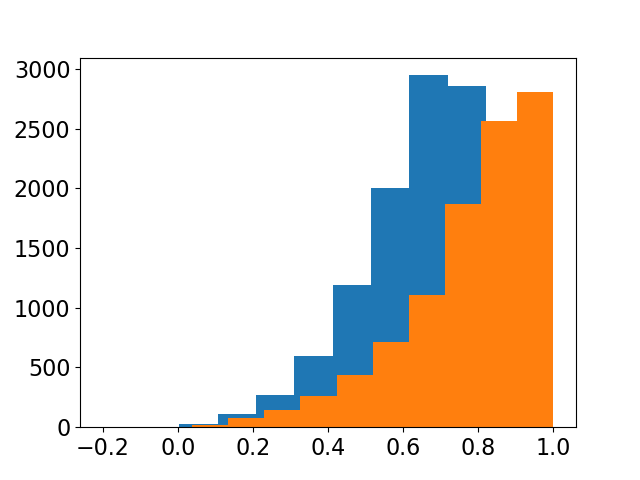

In [8]:
fig,ax = plt.subplots()
ax.hist(minsr2/maxsr2)
ax.hist(middle2/maxsr2)

(array([4.200e+01, 6.713e+03, 1.883e+03, 8.210e+02, 3.290e+02, 1.350e+02,
        3.800e+01, 2.000e+01, 1.300e+01, 6.000e+00]),
 array([-0.25751621, -0.08795967,  0.08159687,  0.25115341,  0.42070994,
         0.59026648,  0.75982302,  0.92937955,  1.09893609,  1.26849263,
         1.43804916]),
 <BarContainer object of 10 artists>)

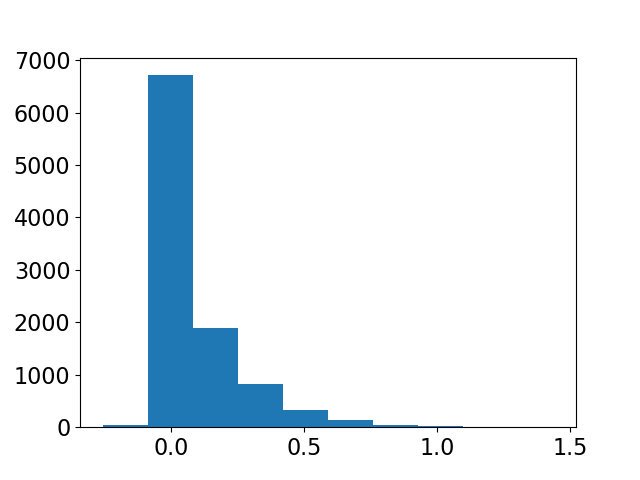

In [9]:
fig,ax = plt.subplots()
deviation = maxsr2**3-middle2**3-minsr2**3
ax.hist(deviation)

In [144]:
np.median(maxsr2**3-minsr2**3-middle2**3),np.mean(maxsr2**2-minsr2**2-middle**2)

(0.02085442974142919, -0.04255720227262751)